## Train LSTM model 

In [58]:
# Import required modules
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'; 
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn import metrics as skmetrics
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [1]:
# Project folder
BASE_DIR = os.getcwd()
# Data folder
DATA_DIR = os.path.join(BASE_DIR, "data")
# Model folder
MODEL_DIR = os.path.join(BASE_DIR, "model")

In [3]:
# Load data
df = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"), header=None)
#df = pd.read_csv('data_train.csv', header=None)
df.head()

NameError: name 'pd' is not defined

In [61]:
'''
    *** Fixed parameters that are defined and should not be changed
'''
NUM_XSENS = 4
INPUT_FEATURES = NUM_XSENS * 6

In [62]:
'''
    *** Parameters that should be tuned to solve the challenge ***
'''

# Number of tasks to classify (according to your experimental acquisition protocol)
N_CLASSES = 4 
# Length of the time window
WINDOW_LENGTH = 5
# Stride length (i.e., overlap between adjacent windows)
STRIDE_LENGTH = 1

# Learning rate
learning_rate = 1e-3
# Number of neurons for each LSTM layer
neurons = [40, 20]
# Dropout ratio for each LSTM layer 
dropouts = [0.15, 0.15]
# Number of training epochs
N_EPOCHS = 5
# Batch size for training
batch_size = 32

# Please provide a dropout value for each LSTM layer
# Set dropout[i] = 0.0 to keep all connections
assert(len(neurons) == len(dropouts))

In [63]:
# Data preparation
X = df.iloc[:,0:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()
y = tf.keras.utils.to_categorical(y)

print("Input shape (X): {} --- Output shape (y): {}".format(X.shape, y.shape))

Input shape (X): (84363, 24) --- Output shape (y): (84363, 4)


In [64]:
def build_sequences(df, y, window_length, input_features, stride):
    # Sanity check to avoid runtime errors
    assert window_length % stride == 0
    dataset = []; labels = []
    # Take only meaningful features
    if type(df) == pd.core.frame.DataFrame:
        temp = df.copy().values
    else:
        temp = df
    # Compute padding length
    padding_len = window_length - len(temp)%window_length
    # Create padding and concatenate it
    padding = np.zeros((padding_len, input_features), dtype='float64')
    temp = np.concatenate((temp,padding))
    # Build features windows with their corresponding labels
    idx = 0
    while idx+window_length < len(temp):
        dataset.append(temp[idx:idx+window_length])
        labels.append(y[idx])
        idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [65]:
'''
    NOTE: in this example, we open a single file and we apply the train_test_split function
          to extract 80% for training and 20% for testing the model.
          In your code, you will need to load 2 files, 1 for training and 1 for testing
'''

# Use stratify=y to stratify on y (target variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train sets shape: {} {}".format(X_train.shape, y_train.shape))
print("Train sets shape: {} {}".format(X_test.shape, y_test.shape))


Train sets shape: (67490, 24) (67490, 4)
Train sets shape: (16873, 24) (16873, 4)


In [66]:
# Fit and trasnform with scaler
scaler = sklearn.preprocessing.MinMaxScaler((-1,1))
scaler.fit(X_train)

# Scale input (X) data 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
# Convert to sequences of length WINDOW_LENGTH
X_train, y_train = build_sequences(X_train, y_train, window_length=WINDOW_LENGTH, input_features=INPUT_FEATURES, stride=STRIDE_LENGTH)
X_test, y_test = build_sequences(X_test, y_test, window_length=WINDOW_LENGTH, input_features=INPUT_FEATURES, stride=STRIDE_LENGTH)

print("Train sets shape: {} {}".format(X_train.shape, y_train.shape))
print("Train sets shape: {} {}".format(X_test.shape, y_test.shape))

Train sets shape: (33744, 6, 24) (33744, 4)
Train sets shape: (8436, 6, 24) (8436, 4)


In [68]:
# LSTM model 
def lstm_model(neurons=neurons, dropouts=dropouts, learning_rate=learning_rate, output_classes=N_CLASSES, window=WINDOW_LENGTH, features=INPUT_FEATURES):
    # Input layer
    input_layer = tf.keras.layers.Input((window, features))
    x = input_layer
    # Build the model recursively based on the list of neurons for each LSTM cell
    # Add a dropout layer after every LSTM layer
    for i in range(len(neurons)):
        y = tf.keras.layers.LSTM(neurons[i], activation = "tanh", return_sequences = not(i == len(neurons)-1), kernel_initializer = "HeUniform")(x)
        y = tf.keras.layers.Dropout(dropouts[i])(y)
        x = y
    # Output layer with N_CLASSES neurons: each provides the probability that the input belongs to that class (their sum equals 1)
    output_layer = tf.keras.layers.Dense(output_classes, activation='softmax', kernel_initializer="RandomNormal", name='output_layer')(x)
    # Build the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='task-classifier')
    # Optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    # Compile and return the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [69]:
# Create the LSTM model and print its structure
model = lstm_model()
model.summary()

Model: "task-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 24)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 6, 40)             10400     
                                                                 
 dropout_6 (Dropout)         (None, 6, 40)             0         
                                                                 
 lstm_7 (LSTM)               (None, 20)                4880      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 output_layer (Dense)        (None, 4)                 84        
                                                                 
Total params: 15,364
Trainable params: 15,364
Non-t

In [70]:
# Fit with train data (NOTE: early stopping is active)
# Read more here: https://keras.io/api/callbacks/early_stopping/
history = model.fit(X_train.reshape(-1, WINDOW_LENGTH, INPUT_FEATURES), y_train, 
          epochs=N_EPOCHS,
          batch_size=batch_size, 
          validation_data=(X_test.reshape(-1, WINDOW_LENGTH, INPUT_FEATURES), y_test),
          callbacks=EarlyStopping(monitor='val_loss', patience=8, mode='min', restore_best_weights=True))

Epoch 1/5
1055/1055 [==============================] - 5s 3ms/step - loss: 0.7219 - accuracy: 0.7112 - val_loss: 0.4621 - val_accuracy: 0.8338
Epoch 2/5
1055/1055 [==============================] - 3s 3ms/step - loss: 0.4403 - accuracy: 0.8442 - val_loss: 0.3564 - val_accuracy: 0.8752
Epoch 3/5
1055/1055 [==============================] - 3s 3ms/step - loss: 0.3626 - accuracy: 0.8754 - val_loss: 0.3134 - val_accuracy: 0.8826
Epoch 4/5
1055/1055 [==============================] - 3s 3ms/step - loss: 0.3055 - accuracy: 0.8941 - val_loss: 0.2516 - val_accuracy: 0.9107
Epoch 5/5
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2711 - accuracy: 0.9051 - val_loss: 0.2331 - val_accuracy: 0.9187


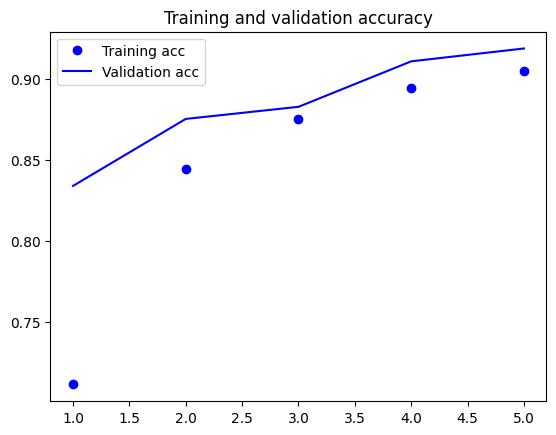

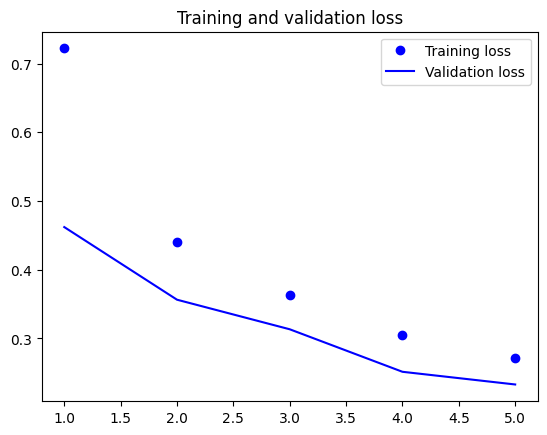

In [71]:
# Plot training history (loss and accuracy)
epochs = range(1, N_EPOCHS+1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [72]:
# Model evaluation
y_pred = model.predict(X_test.reshape(-1, WINDOW_LENGTH, INPUT_FEATURES), 
                       batch_size=1,   # predict with batch_size = 1 for real-time use                
)
y_pred = np.argmax(y_pred, axis=-1) # Convert to Nx1 array
y_test = np.argmax(y_test, axis=-1)

print("Test accuracy: {:4.2f} %".format(100*skmetrics.accuracy_score(y_test, y_pred)))

8436/8436 [==============================] - 5s 529us/step
Test accuracy: 91.87 %


In [73]:
# Save model for real-time use
try:
    os.makedirs(MODEL_DIR)
except FileExistsError:
    pass
try:
    os.makedirs(MODEL_DIR)
except FileExistsError:
    pass

model.save(os.path.join(MODEL_DIR, "{}.h5".format(model.name)))
with open(os.path.join(MODEL_DIR, "{}_scaler.h5".format(model.name)), 'wb') as f:
    pickle.dump(scaler,f)

print("Model exported to {}".format(MODEL_DIR))

Model exported to /Users/annasparapani/Library/Mobile Documents/com~apple~CloudDocs/Cartelle iMac/UNI /LMagistrale/Corsi/2.1 Neuroengineering/NE[2] Pedrocchi/Project Workshop/PW RR code/tensorflow/model
